## Exploration

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from scipy.optimize import fmin
import matplotlib.pyplot as plt

m = np.array([
    0.487, 0.572, 0.369, 0.179, 0.119, 0.0809, 0.104, 0.091, 0.047, 0.051
]).reshape(-1, 1)
N = len(m)
t = np.linspace(1, 10, N).reshape(-1,1)
A_0 = 1
sigma = .05 # Not given in the exercise sheet! 

def model(t, theta):
    theta_1, theta_2 = theta
    return theta_1 + (A_0 - theta_1) * np.exp(-theta_2 * t)

print(m)
print(t)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[0.487 ]
 [0.572 ]
 [0.369 ]
 [0.179 ]
 [0.119 ]
 [0.0809]
 [0.104 ]
 [0.091 ]
 [0.047 ]
 [0.051 ]]
[[ 1.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 5.]
 [ 6.]
 [ 7.]
 [ 8.]
 [ 9.]
 [10.]]


Try out random predictions from given model

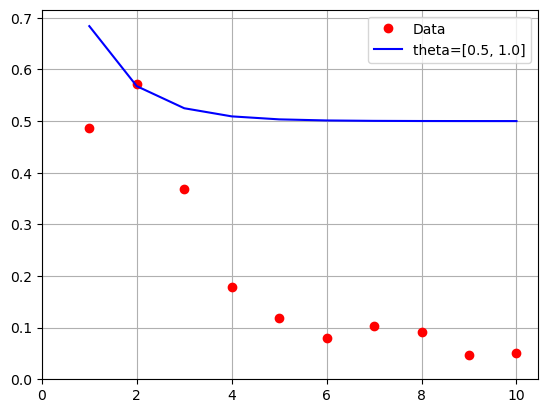

In [2]:
# Make random predictions, say 1/2 and 1.
theta = np.array([.5,1]).T
y_pred = model(t, theta)
plt.plot(t, m, 'ro', label='Data')
plt.plot(t, model(t, theta), 'b-', label=f"theta={theta.tolist()}")
plt.legend()
plt.xlim([0,None])
plt.ylim([0,None])
plt.grid(True)
plt.show()

## 1. Likelihood density

Likelihood function for theta, given measurement $m(t_i)$ at time $t_i$, and our model prediction $f(t_i;\theta)$

$$
L(\theta | y) = P(y | \theta)
    \\ = \prod_{i=0}^{N} P(m(t_i) | \theta)
    \\ = \prod_{i=0}^{N} \frac{1}{\sqrt{(2\pi)^p | \Sigma |} } \exp( - \frac{1}{2} ( m(t_i) - f(t_i;\theta) )^T \Sigma^{-1} ( m(t_i) - f(t_i;\theta) ) )
$$
$$
    \\ = \frac{1}{\sqrt{(2\pi)^N|\sigma^2 I|}} \exp( -\frac{1}{2}  \frac{ \sum_{i=1}^{N}{  ( m(t_i) - f(t_i;\theta) )^2  } } {\sigma^2}  )
$$


Where $p = 1$ is dimension of each observation $y$, $m = 10$ is the number of data points  and covariance matrix $\Sigma = \sigma I$, where $I$ is identity matrix.

We derive negative log-likelihood:

$$
    -\log(L(\theta | y))
    \\ = -\log( \frac{1}{\sqrt{(2\pi)^N|\sigma^2 I|}} \exp( -\frac{1}{2}  \frac{ \sum_{i=1}^{N}{  ( m(t_i) - f(t_i;\theta) )^2  } } {\sigma^2}  ) )
$$
$$
    \\ = \log(\sqrt{(2\pi)^N|\sigma^2 I|} ) + \frac{1}{2}  \frac{1}{ {\sigma^2} } \sum_{i=1}^{N}{  ( m(t_i) - f(t_i;\theta) )^2  }
    \\ = N/2\log({2\pi}) - 2N\log(\sigma) - \frac{1}{2\sigma^2} \sum_{i=1}^{N}{  ( m(t_i) - f(t_i;\theta) )^2  }
$$

If we plug in our model definition, we get

$$
NLL(\theta|m) = N/2\log({2\pi}) - 2N\log(\sigma) - \\
 \frac{1}{2\sigma^2} \sum_{i=1}^{N}{  ( m(t_i) - ( \theta_1 + (A_0  - \theta_1)\exp(-\theta_2 t_i)) )^2  }
$$

# 2. Maximum likelihood estimation:

Random uniform theta [[0.3745401188473625], [0.9507143064099162]]
Optimization terminated successfully.
         Current function value: -57.996623
         Iterations: 45
         Function evaluations: 86
Theta found through optimization [0.03927841560506069, 0.43064289081622453]


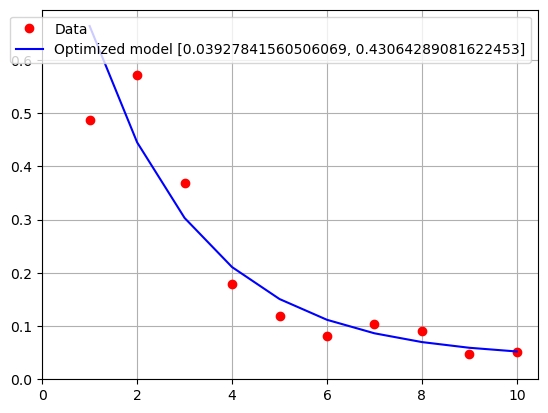

In [3]:
np.random.seed(42)


def log_likelihood(theta, t, m, sigma):
    N,p = m.shape
    return (N / 2 * np.log(2 * np.pi) - 2*N*np.log(sigma) - \
            1/(2 * sigma**2) * np.sum( (m - model( t, theta ))**2 ))

def NLL(theta, t, m, sigma):
    return -log_likelihood(theta, t, m, sigma)

theta = np.random.uniform(0,1,size=(2,1))

print("Random uniform theta", theta.tolist())

theta_optimized = fmin(NLL, x0=theta, args=(t, m, sigma))

print(f"Theta found through optimization {theta_optimized.tolist()}")

m_opt = model(t, theta_optimized)
plt.plot(t, m, 'ro', label='Data')
plt.plot(t, m_opt, 'b-', label=f'Optimized model {theta_optimized.tolist()}')
plt.legend()
plt.xlim([0,None])
plt.ylim([0,None])
plt.grid(True)
plt.show()

## 3. Compute conditional mean estimate

In [4]:
from tqdm import tqdm
from scipy import stats
import seaborn as sns

Metropolis hastings algorithm.

In [19]:
from functools import lru_cache

def target_distribution(theta):
    y_pred = model(t, theta)
    likelihood = stats.norm.pdf(m, y_pred, sigma).prod()
    return likelihood

def metropolis_hastings(initial_theta, num_samples):
    current_theta = initial_theta
    samples = [current_theta]

    for _ in tqdm(range(num_samples)):
        # Proposal distribution: Normal distribution centered at the current value
        proposal_theta = current_theta + stats.norm(0, 0.1).rvs(size=2)

        # Acceptance ratio
        alpha = min(1, target_distribution(proposal_theta) / target_distribution(current_theta))
    
        # Accept or reject
        if np.random.rand() < alpha:
            current_theta = proposal_theta

        samples.append(current_theta)

    return np.array(samples)


# Running the Metropolis-Hastings algorithm
initial_theta = np.array([0.02, 0.5])  # Initial guess
num_samples = 10000
theta_samples = metropolis_hastings(initial_theta, num_samples)

# Computing the conditional mean estimate
conditional_mean_estimate = theta_samples.mean(axis=0)
print("Conditional Mean Estimate of Theta:", conditional_mean_estimate)

100%|██████████| 10000/10000 [00:07<00:00, 1344.80it/s]

Conditional Mean Estimate of Theta: [0.03780944 0.43670864]


Adaptive Metropolis algorithm

In [7]:
def adaptive_metropolis(initial_theta, num_samples):
    current_theta = initial_theta
    samples = [current_theta]

    # Initial covariance matrix for the proposal distribution
    cov_matrix = np.eye(2) * 0.1

    for i in tqdm(range(1, num_samples + 1)):
        # Proposal distribution: Multivariate normal distribution with adaptive covariance
        proposal_theta = current_theta + np.random.multivariate_normal(mean=np.zeros(2), cov=cov_matrix)

        # Acceptance ratio
        alpha = min(1, target_distribution(proposal_theta) / target_distribution(current_theta))

        # Accept or reject
        if np.random.rand() < alpha:
            current_theta = proposal_theta

        samples.append(current_theta)

        # Update the covariance matrix using the adaptive scheme
        if i % 100 == 0:
            sample_subset = np.array(samples[-100:])
            cov_matrix = np.cov(sample_subset, rowvar=False)

    return np.array(samples)

# Running the Adaptive Metropolis algorithm
theta_samples_adaptive = adaptive_metropolis(initial_theta, num_samples)

# Computing the conditional mean estimate
conditional_mean_estimate_adaptive = theta_samples_adaptive.mean(axis=0)
print("Conditional Mean Estimate of Theta (Adaptive Metropolis):", conditional_mean_estimate_adaptive)

100%|██████████| 10000/10000 [00:02<00:00, 3526.24it/s]

Conditional Mean Estimate of Theta (Adaptive Metropolis): [0.03962474 0.44016988]


In [31]:
def adaptive_metropolis_delayed_rejection(initial_theta, num_samples, num_stages=2):
    current_theta = initial_theta
    samples = [current_theta]

    # Initial covariance matrix for the proposal distribution
    cov_matrix = np.eye(2) * 0.1

    for i in range(1, num_samples + 1):
        # Proposal distribution: Multivariate normal distribution with adaptive covariance
        proposal_theta = current_theta + np.random.multivariate_normal(mean=np.zeros(2), cov=cov_matrix)

        # Acceptance ratio for the initial proposal
        p_current = target_distribution(current_theta)
        if p_current > 0:
            alpha = min(1, target_distribution(proposal_theta) / p_current)
        else:
            alpha = 1

        # Delayed rejection stages
        for stage in range(1, num_stages + 1):
            # New proposal for delayed rejection
            proposal_theta_delayed = current_theta + np.random.multivariate_normal(mean=np.zeros(2), cov=cov_matrix / (2 ** stage))

            # Acceptance ratio for the delayed proposal
            # alpha_delayed = min(1, target_distribution(proposal_theta_delayed) / target_distribution(current_theta))
            p_current = target_distribution(current_theta)
            if p_current > 0:
                alpha_delayed = min(1, target_distribution(proposal_theta) / p_current)
            else:
                alpha_delayed = 1

            # Combine acceptance ratios for the initial and delayed proposals
            rho = np.exp(stage * (np.log(alpha_delayed) - np.log(alpha)))
            if np.random.rand() < rho:
                current_theta = proposal_theta_delayed
                alpha = alpha_delayed

        # Accept or reject based on the final acceptance ratio
        if np.random.rand() < alpha:
            current_theta = proposal_theta

        samples.append(current_theta)

        # Update the covariance matrix using the adaptive scheme
        if i % 100 == 0:
            sample_subset = np.array(samples[-100:])
            cov_matrix = np.cov(sample_subset, rowvar=False)

    return np.array(samples)

# Running the Adaptive Metropolis algorithm
num_stages = 0
theta_samples_delayed_rejection = adaptive_metropolis_delayed_rejection(initial_theta, num_samples, num_stages)

# Computing the conditional mean estimate
conditional_mean_estimate_adaptive = theta_samples_adaptive.mean(axis=0)
print("Conditional Mean Estimate of Theta (Adaptive Metropolis):", conditional_mean_estimate_adaptive)

Conditional Mean Estimate of Theta (Adaptive Metropolis): [0.03962474 0.44016988]


In [32]:
def dr_adaptive_metropolis(initial_theta, num_samples, num_stages=2):
    current_theta = initial_theta
    samples = [current_theta]

    # Initial covariance matrix for the proposal distribution
    cov_matrix = np.eye(2) * 0.1

    for i in range(1, num_samples + 1):
        # Proposal distribution: Multivariate normal distribution with adaptive covariance
        proposal_theta = current_theta + np.random.multivariate_normal(mean=np.zeros(2), cov=cov_matrix)

        # Acceptance ratio for the initial proposal
        alpha = min(1, target_distribution(proposal_theta) / (target_distribution(current_theta) + 1e-10))
        
        # Delayed rejection stages
        for stage in range(1, num_stages + 1):
            # New proposal for delayed rejection
            proposal_theta_delayed = current_theta + np.random.multivariate_normal(mean=np.zeros(2), cov=cov_matrix / (2 ** stage))

            # Acceptance ratio for the delayed proposal
            alpha_delayed = min(1, target_distribution(proposal_theta_delayed) / (target_distribution(current_theta) + 1e-10))

            # Combine acceptance ratios for the initial and delayed proposals
            rho = np.exp(stage * (np.log(alpha_delayed) - np.log(alpha)))
            if np.random.rand() < rho:
                current_theta = proposal_theta_delayed
                alpha = alpha_delayed

        # Accept or reject based on the final acceptance ratio
        if np.random.rand() < alpha:
            current_theta = proposal_theta

        samples.append(current_theta)

        # Update the covariance matrix using the adaptive scheme
        if i % 100 == 0:
            sample_subset = np.array(samples[-100:])
            cov_matrix = np.cov(sample_subset, rowvar=False)

    return np.array(samples)

# Running the Delayed Rejection Adaptive Metropolis algorithm
theta_samples_dram = dr_adaptive_metropolis(initial_theta, num_samples, num_stages)

# Computing the conditional mean estimate
conditional_mean_estimate_dram = theta_samples_dram.mean(axis=0)
print("Conditional Mean Estimate of Theta (DRAM):", conditional_mean_estimate_dram)

Conditional Mean Estimate of Theta (DRAM): [0.03310936 0.43125787]


Delayed rejection.

# Priors

(derivation is mostly same as in previous exercise)

Let's define gaussian prior to be

$$
    P(\theta)=(2\pi)^{-1}|\Sigma|^{-1/2}\exp(-1/2(\theta-\mu)^T\Sigma^{-1}(\theta-\mu))
$$

Where $\mu=(0.4,3.0)^T$ and $\Sigma=\sigma^2 I$. It's logarithm would be

Now, negative log prior would be:

$$
\log(2\pi) + 2\log\sigma + 1/(2\sigma) \sum_{i=1}^{2}(\theta_i-\mu_i)^2
$$

Define negative log posterior:
$$
NLP(\theta) = -\log(P(\theta | y)) = -\log(P(y | \theta)) - \log(P(\theta)) + \log(P(y))
$$

We already calculated $-\log(P(y | \theta))$, this is just Negative log likelihood. We plug that in to get
$$
NLP(\theta) = m/2\log({2\pi}) - 2m\log(\sigma) 
 - \frac{1}{2\sigma^2} \sum_{i=1}^{N}{  ( y^{(i)} - ( \theta_1 + (A_0  - \theta_1)\exp(-\theta_2 t_i)) )^2   }
$$

$$
\\ - \log(P(\theta)) + \log(P(y))
$$

In this case, we use numerical minimizer `L-BFGS-B` to find the MAP estimate. 

Normal prior:

In [44]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize

# Gaussian prior parameters
prior_mean = np.array([0.5, 0.5])
prior_covariance = np.diag([0.1, 0.1])  # Adjust based on the strength of the prior

# Gaussian prior log probability
def log_prior(theta):
    return stats.multivariate_normal.logpdf(theta, mean=prior_mean, cov=prior_covariance)

# Negative log posterior
def neg_log_posterior(theta):
    return - (np.log(target_distribution(theta) + 1e-10) + log_prior(theta))

def metropolis_hastings(initial_theta, num_samples, prior_fn: callable):
    current_theta = initial_theta
    samples = [current_theta]

    for _ in tqdm(range(num_samples)):
        # Proposal distribution: Multivariate normal distribution
        proposal_theta = current_theta + stats.multivariate_normal(mean=np.zeros(2), cov=np.eye(2) * 0.1).rvs()

        # Acceptance ratio
        alpha = min(1, np.exp(target_distribution(proposal_theta) + prior_fn(proposal_theta) - target_distribution(current_theta) - prior_fn(current_theta)))

        # Accept or reject
        if np.random.rand() < alpha:
            current_theta = proposal_theta

        samples.append(current_theta)

    return np.array(samples)

# Optimization for MAP estimator
initial_guess = np.array([0.02, 0.5])
opt = optimize.minimize(neg_log_posterior, initial_guess, method='L-BFGS-B')
map_estimator = opt['x']


theta_samples_prior = metropolis_hastings(initial_theta, num_samples=10000, prior_fn=log_prior)
cm_estimator = theta_samples_prior.mean(axis=0)


print("MAP Estimator:", map_estimator)
print("CM Estimator:", cm_estimator)


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_74131/3202927897.py:26: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp(target_distribution(proposal_theta) + prior_fn(proposal_theta) - target_distribution(current_theta) - prior_fn(current_theta)))
100%|██████████| 10000/10000 [00:07<00:00, 1354.52it/s]

MAP Estimator: [0.04447409 0.43786538]
CM Estimator: [0.04132268 0.43454535]


In [45]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize

# Gaussian prior parameters

def log_prior(theta):
    in_range = ((theta <= 1) & (theta >= 0)).all()
    return 0 if in_range else -np.inf

# Negative log posterior
def neg_log_posterior(theta):
    return - (np.log(target_distribution(theta) + 1e-10) + log_prior(theta))

# Optimization for MAP estimator
initial_guess = np.array([0.02, 0.5])
opt = optimize.minimize(neg_log_posterior, initial_guess, method='L-BFGS-B')
map_estimator = opt['x']

theta_samples_prior = metropolis_hastings(initial_theta, num_samples=10000, prior_fn=log_prior)
cm_estimator = theta_samples_prior.mean(axis=0)

print("MAP Estimator:", map_estimator)
print("CM Estimator:", cm_estimator)

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_74131/3202927897.py:26: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp(target_distribution(proposal_theta) + prior_fn(proposal_theta) - target_distribution(current_theta) - prior_fn(current_theta)))
100%|██████████| 10000/10000 [00:04<00:00, 2016.61it/s]

MAP Estimator: [0.03926439 0.43059739]
CM Estimator: [0.03668916 0.42329098]


  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_74131/3202927897.py:26: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp(target_distribution(proposal_theta) + prior_fn(proposal_theta) - target_distribution(current_theta) - prior_fn(current_theta)))
100%|██████████| 5000/5000 [00:02<00:00, 1958.24it/s]


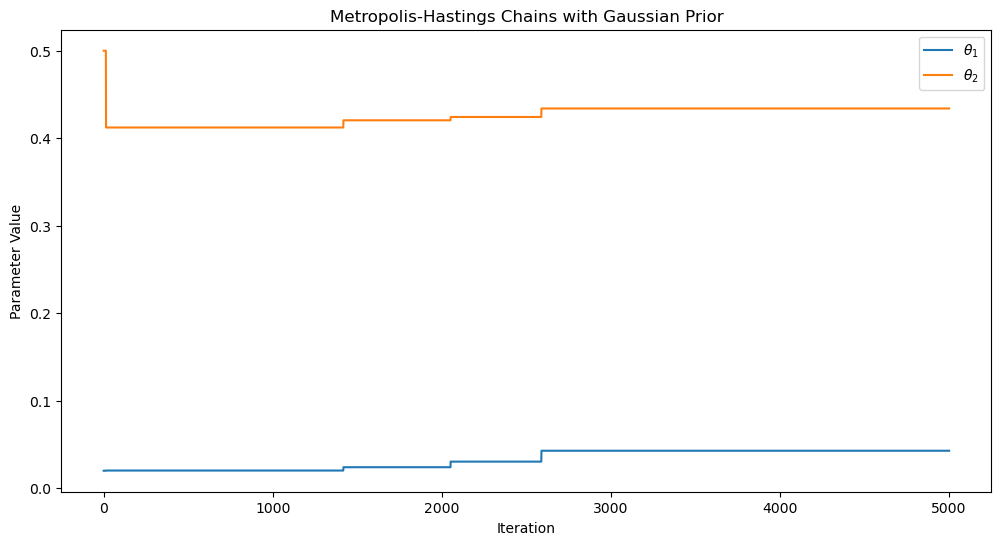

In [46]:
import numpy as np
import matplotlib.pyplot as plt
# import emcee
# import corner
from scipy.stats import gaussian_kde

# Gaussian prior parameters
prior_mean = np.array([0.5, 0.5])
prior_covariance = np.diag([0.1, 0.1])  # Adjust based on the strength of the prior

# Running the Metropolis-Hastings algorithm with Gaussian prior
initial_theta = np.array([0.02, 0.5])  # Initial guess
num_samples = 5000
theta_samples_gaussian_prior = metropolis_hastings(initial_theta, num_samples, log_prior)

# Plotting chains
plt.figure(figsize=(12, 6))
plt.plot(theta_samples_gaussian_prior[:, 0], label=r'$\theta_1$')
plt.plot(theta_samples_gaussian_prior[:, 1], label=r'$\theta_2$')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Metropolis-Hastings Chains with Uniform Prior')
plt.legend()
plt.show()

Welp... I'm out of time. I'll try to outline on what else needs to be done.

> Generate suitable predictive envelopes around the best fit model.

Since we have a way to generate samples from posterior distribution, I'd simulate new datasets with these synthetic samples. We can then make prediction intervals for each dataset and obtain percntiles of predicted values. We can then use those percentiles as the envelope.

> "How would handle the fact that observations are constrained to
positive?"

I'd do a log-transform on the parameters (theta) to ensure positivity. 

> Add A0 as an extra paramet

 adding A_0 as an extra parameter would just mean us making proposals of shape (3,1), and also adjusting the priors to have (3,1) shape. 